# Cell density and composition

In this notebook you will analyze and validate the circuit anatomy in terms of cell density and composition.

### Cell density

In this section, you will calculate the cell density.

The cell density is defined as the number of cells per volume and usually express as $10^3 / \textrm{mm}^3$

---

Import some python packages

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import nrrd
import matplotlib.pyplot as plt

# package to work with the circuit
from bluepysnap import Circuit
from bluepysnap.bbp import Cell

Reading and preparing the data.

In [2]:
circuit_path = '/home/data-bbp/20191017/circuit_config.json'
atlas_directory = '/home/data-bbp/20191017/atlas'
circuit = Circuit(circuit_path)
cells = circuit.nodes["hippocampus_neurons"]
conn = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical"]

In [3]:
br_data, br_metadata = nrrd.read(Path(atlas_directory, "brain_regions.nrrd"))

# hierarchy contains the region hierarchy: 01 -> [mc0->[mc0;SO, mc0;SP, ...], mc1-> [mc1;SO, mc1;SP, ...], ...]
hierarchy = json.load(open(Path(atlas_directory, "hierarchy.json")))

In [4]:
O1_columns = hierarchy["children"]
O1_column_names = [column["acronym"] for column in O1_columns]

Initialize table to store the results.

In [5]:
regions = ['CA1', 'SLM', 'SR', 'SP', 'SO'] # list of regions we are going to analyze
df = pd.DataFrame(index=regions, columns=O1_column_names) # the analysis will be done in the 7 columns separately

In [6]:
df

mc0  mc1  mc2  mc3  mc4  mc5  mc6
CA1  NaN  NaN  NaN  NaN  NaN  NaN  NaN
SLM  NaN  NaN  NaN  NaN  NaN  NaN  NaN
SR   NaN  NaN  NaN  NaN  NaN  NaN  NaN
SP   NaN  NaN  NaN  NaN  NaN  NaN  NaN
SO   NaN  NaN  NaN  NaN  NaN  NaN  NaN

Since you will apply the same calculation for different cases, better to create a helper function.

In [7]:
def region_volume(brain_region, brain_region_metadata, labels):
    '''Helper function that takes the region name and gives it total volume
    including the scaling factor to convert from 1/um^3 to 10^3/mm^3'''
    scale = 1000000 # convert factor from 1/um^3 to 10^3/mm^3
    count = np.count_nonzero(np.in1d(brain_region, labels))
    spacing = brain_region_metadata["space directions"].diagonal()
    voxel_volume = abs(np.product(spacing))
    return count*voxel_volume/scale

This is where you calculate the cell density for several subset of cells and in each column.

In [8]:
for column in O1_columns:
    column_name = column["acronym"]
    
    # retrieve the acronyms and the labels for all brain regions in the corresponding column
    acronyms_labels = [(region['acronym'], region['id']) for region in column["children"]]
    # Get the labels from the brain region atlas corresponding to the current column 
    column_labels = [acronym_label[1] for acronym_label in acronyms_labels]
    
    # cell gids in the current column
    region_str_regex = '{};.*'.format(column_name)
    column_gids = cells.ids({Cell.REGION: {'$regex': region_str_regex}}) 
    
    # compute density 
    column_density = len(column_gids)/region_volume(br_data, br_metadata, column_labels)
    
    # fill the data frame
    df.loc["CA1"][column_name] = column_density
    
    for acronym, label in acronyms_labels:
        # get the gids for the current region
        region_gids = cells.ids({Cell.REGION: acronym})
        # compute the density of the region
        region_density = len(region_gids)/ region_volume(br_data, br_metadata, label)
        # fill the dataframe
        df.loc[acronym.split(";")[-1]][column_name] = region_density

In [9]:
df

mc0        mc1        mc2        mc3       mc4       mc5        mc6
CA1    25.5832    26.8188    25.0575    26.0404   25.8332   26.5201    25.4668
SLM          0          0          0  0.0435161         0  0.043802  0.0435161
SR   0.0708617  0.0469307  0.0713335  0.0932488  0.117327  0.211188   0.163185
SP      278.77    291.721    273.635     283.29   281.318   287.998    276.327
SO    0.816993    1.08217   0.587452   0.921517  0.811626  0.927572    1.03671

Calculate mean and standard deviation acress the columns.

In [10]:
means = df.mean(axis=1)
stds = df.std(axis=1)
df['mean'] = means
df['std'] = stds
df.head()

mc0        mc1        mc2        mc3       mc4       mc5  \
CA1    25.5832    26.8188    25.0575    26.0404   25.8332   26.5201   
SLM          0          0          0  0.0435161         0  0.043802   
SR   0.0708617  0.0469307  0.0713335  0.0932488  0.117327  0.211188   
SP      278.77    291.721    273.635     283.29   281.318   287.998   
SO    0.816993    1.08217   0.587452   0.921517  0.811626  0.927572   

           mc6        mean       std  
CA1    25.4668   25.902871  0.612461  
SLM  0.0435161    0.018691  0.023311  
SR    0.163185    0.110582  0.058316  
SP     276.327  281.865737  6.391032  
SO     1.03671    0.883434  0.165107

### Cell composition

In this section you count how many cells you have for each morphological types or m-types and in each 'column'.

You have already prepared the data in the first part, you only need to query the different m-types in the circuit.

In [11]:
mtypes = cells.property_values(Cell.MTYPE)

Initialize table to store the results.

In [12]:
composition = pd.DataFrame(index=mtypes, columns=O1_column_names)
composition.head()

mc0  mc1  mc2  mc3  mc4  mc5  mc6
SP_CCKBC  NaN  NaN  NaN  NaN  NaN  NaN  NaN
SP_PVBC   NaN  NaN  NaN  NaN  NaN  NaN  NaN
SP_BS     NaN  NaN  NaN  NaN  NaN  NaN  NaN
SO_OLM    NaN  NaN  NaN  NaN  NaN  NaN  NaN
SR_SCA    NaN  NaN  NaN  NaN  NaN  NaN  NaN

Compute the number of cells for each m-types and in each column.

In [13]:
# calculate the number of cells
for column in O1_columns:
    column_acronym = column["acronym"]
    region_str_regex = '{};.*'.format(column_acronym)
    for mtype in mtypes:
        composition[column_acronym][mtype] = cells.count({Cell.MTYPE: mtype, Cell.REGION: {'$regex': region_str_regex}})

In [14]:
composition

mc0   mc1   mc2   mc3   mc4   mc5   mc6
SP_CCKBC    36    21    16    25    23    37    37
SP_PVBC     36    49    44    43    38    36    53
SP_BS       15    12     6    15    15    15    13
SO_OLM      10    15     7     9    14    16    17
SR_SCA       3     2     3     4     5     9     7
SP_AA       12    10    10     9    12    19     8
SO_BS        5     4     2     3     5     1     4
SP_Ivy      63    68    53    70    75    72    76
SO_BP        1     1     0     2     1     2     3
SLM_PPA      0     0     0     1     0     1     1
SP_PC     2367  2504  2337  2442  2406  2451  2353
SO_Tri       5     8     6    10     1     5     3

Calculate mean and standard deviation acress the columns.

In [15]:
means = composition.mean(axis=1)
stds = composition.std(axis=1)
composition['mean'] = means
composition['std'] = stds
composition

mc0   mc1   mc2   mc3   mc4   mc5   mc6         mean        std
SP_CCKBC    36    21    16    25    23    37    37    27.857143   8.687703
SP_PVBC     36    49    44    43    38    36    53    42.714286   6.575568
SP_BS       15    12     6    15    15    15    13    13.000000   3.316625
SO_OLM      10    15     7     9    14    16    17    12.571429   3.866831
SR_SCA       3     2     3     4     5     9     7     4.714286   2.497618
SP_AA       12    10    10     9    12    19     8    11.428571   3.644957
SO_BS        5     4     2     3     5     1     4     3.428571   1.511858
SP_Ivy      63    68    53    70    75    72    76    68.142857   7.988086
SO_BP        1     1     0     2     1     2     3     1.428571   0.975900
SLM_PPA      0     0     0     1     0     1     1     0.428571   0.534522
SP_PC     2367  2504  2337  2442  2406  2451  2353  2408.571429  60.511313
SO_Tri       5     8     6    10     1     5     3     5.428571   2.992053

### EI ratio

In this section, you calculate the EI ratio, i.e. the ratio beween the number of Excitatory and Inhibitory cells. EI ratio is often express as percentages of cells.

The EI ratio gives you an idea of the balance between excitation and inhibition, and that may have a profound effect on the network activity.

---

You have already prepared the data in the first part, you only need to initialize the table to store the results.

In [16]:
rows = ['EXC', 'INH', 'EXC%']

ratio = pd.DataFrame(index=rows, columns=O1_column_names)

Calculate the number of Excitatory and Inhibitory cells in each column.

In [17]:
for column in O1_columns:
    column_acronym = column['acronym']
    region_str_regex = '{};.*'.format(column_acronym)
    for target in ['EXC', 'INH']:
        ratio[column_acronym][target] = cells.count({Cell.SYNAPSE_CLASS: target, Cell.REGION: {'$regex': region_str_regex}})

Convert the excitatory cell counts to percentage and fill the corresponding row in the table

In [18]:
# calculate percentage of exhitatory cells (EI ratio)
ratio.loc['EXC%'] = ratio.loc['EXC']*100/(ratio.loc['EXC']+ratio.loc['INH'])
ratio

mc0      mc1      mc2      mc3      mc4      mc5      mc6
EXC      2367     2504     2337     2442     2406     2451     2353
INH       186      190      147      191      189      213      222
EXC%  92.7145  92.9473  94.0821  92.7459  92.7168  92.0045  91.3786

Calculate mean and standard deviation across the columns

In [19]:
means = ratio.mean(axis=1)
stds = ratio.std(axis=1)
ratio['mean'] = means
ratio['std'] = stds
ratio.head()

mc0      mc1      mc2      mc3      mc4      mc5      mc6  \
EXC      2367     2504     2337     2442     2406     2451     2353   
INH       186      190      147      191      189      213      222   
EXC%  92.7145  92.9473  94.0821  92.7459  92.7168  92.0045  91.3786   

             mean        std  
EXC   2408.571429  60.511313  
INH    191.142857  23.842739  
EXC%    92.655671   0.835660

### Cells positions across layers

Another important aspect of the circuit anatomy is the location of the cells.

In this section, you will show soma locations in different layers.

---

Query the soma location in the space.

In [20]:
df = cells.positions({Cell.REGION: {'$regex': 'mc2;.*'}})
df.head()

x           y           z
21  459.527917  446.874883  422.155077
24  414.635754  462.776287  565.867843
25  288.638556  271.175319  575.173791
44  180.678626  228.322322  586.255334
49  177.868223  176.293609  693.896286

Plot the soma locations to visualize their relationship with layers.

In [21]:
# extract values for plotting
x = df['x'].values
y = df['y'].values

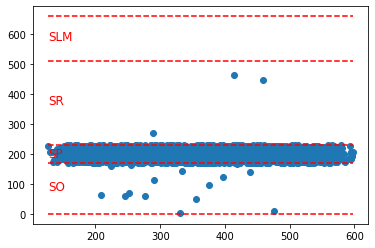

In [22]:
# plot the results
fig, ax = plt.subplots()
ax.scatter(x,y)
layer_heights = (0, 170, 230, 510, 660)
heights = (80, 190, 365, 580)
layers = ('SO', 'SP', 'SR', 'SLM')
ax.hlines(layer_heights, x.min(), x.max(), linestyle='--', colors='r')
for layer, height in zip(layers, heights):
    ax.text(x.min(), height, layer, fontsize=12, color='r')
fig.show()

### Exercise #1
The cell densities calculated above should be compared with literature. Extract data from literature (Aika et al 1994) and compare with the model.

![Aika_etal_1994_Table3](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/Aika_etal_1994_Table3.png)

__Hints__
The table provides more info than you need. For this exercise, focus only on the total number of cells in the entire CA1 and in the different layers. In addition to those 4 datapoints, consider also the PC density in SP.
Furthermore, note that Aika et al considered SLM and SR together (SRLM).

Store answer in two lists, one with data extracted from literature and one with data extrated from the model, each with the order density in CA1 - SRLM - SP - PC density in SP - SO.

### Exercise #2
Location for CCK and SOM cells. Answer will be a comma separated string from SLM to SO without space. For example, location of PV cells is 'SP'. Store answer in two lists, respectively for CCK and SOM.

### Exercise #3
Calculate density for PV, CCK, and SOM cells. Devide the number to the layer volume where they are present. Store answers in a list respecting the order PV, CCK, and SOM.

In [23]:
# Work here 

In [ ]:
# This is to generate the answers to paste in the submission box below.
# Run this and copy-paste the output into the box below
print(json.dumps(dict([("ans_1a", ans_1a),
                       ("ans_1b", ans_1b),
                       ("ans_2a", ans_2a),
                       ("ans_2b", ans_2b),
                       ("ans_3", ans_3)])))

!pip -q install -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client==0.0.5 
import single_cell_mooc_client as sc_mc
s = sc_mc.Submission(hideToken=True)

In [ ]:
# Show submission widget
s.show_submission(ROLLBACK, TOKEN)